# Move To The Directory

In [1]:
%cd ./drive/My\ Drive/perso/Naruto_hand_sign

/content/drive/My Drive/perso/Naruto_hand_sign


# Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import ImageGrid
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import tqdm
import os
import shutil

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.metrics import confusion_matrix

import itertools

%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("The code will run in {}".format(device))

The code will run in cuda


# Fetch and Visualize Data

In [0]:
!unzip ./naruto-hand-sign-dataset.zip

In [3]:
# We'll use these a lot, so make them variables
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

training_transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_nums, std=std_nums) # PyTorch's doc tell us to use the mean and standart deviation of the model
])

test_transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_nums, std=std_nums) # PyTorch's doc tell us to use the mean and standart deviation of the model
])

train_dataset = datasets.ImageFolder('./data/train/', transform=training_transformations)
test_dataset = datasets.ImageFolder('./data/test/', transform=test_transformations)

num_workers = 4
pin_memory = True if device == 'cuda' else 'cpu'
shuffle = True
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=shuffle, pin_memory=pin_memory, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=shuffle, pin_memory=pin_memory, num_workers=num_workers)

print("{} image in the training set splitted into {} mini-batches".format(len(train_dataset), len(train_loader)))
print("{} image in the test set splitted into {} mini-batches".format(len(test_dataset), len(test_loader)))

2159 image in the training set splitted into 68 mini-batches
86 image in the test set splitted into 3 mini-batches


In [0]:
print(train_dataset.classes)

['bird', 'boar', 'dog', 'dragon', 'hare', 'horse', 'monkey', 'ox', 'ram', 'rat', 'snake', 'tiger', 'zero']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

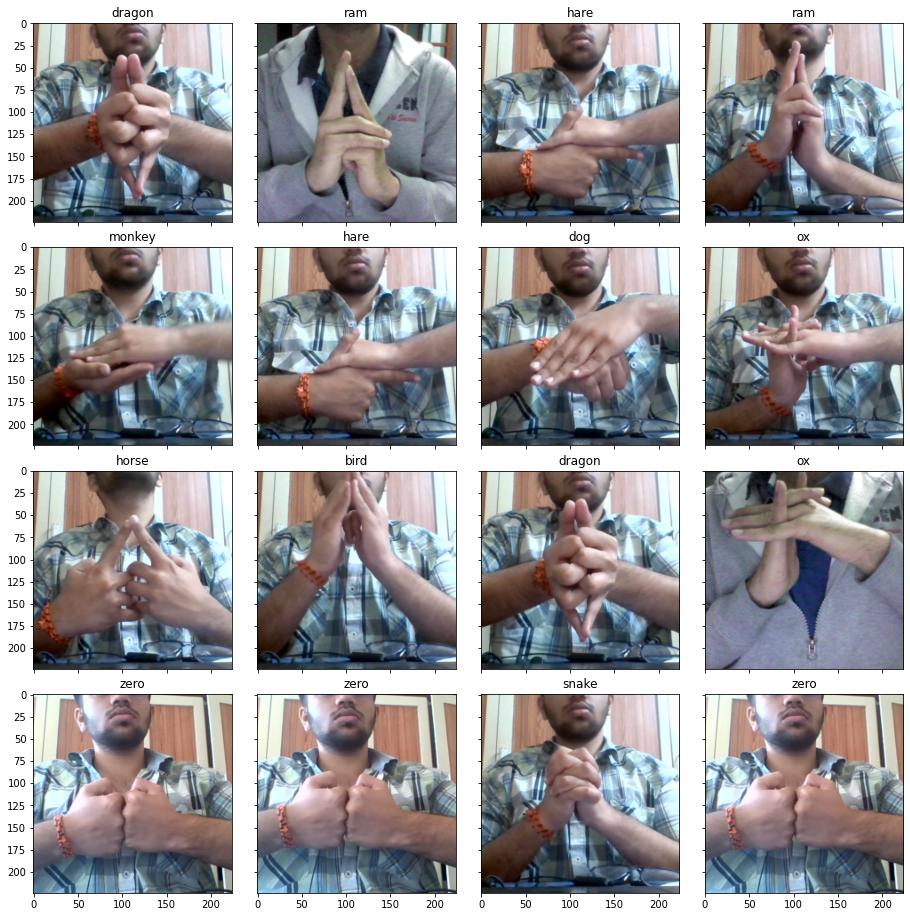

In [4]:
X, y = next(iter(train_loader))

#  Show the data then stops
fig = plt.figure(figsize=(16, 16))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0.35,  # pad between axes in inch.
                 )

for ax, im, lb in zip(grid, X, y):
  # Iterating over the grid returns the Axes.
  inp = np.array(std_nums) * im.permute(1, 2, 0).detach().cpu().numpy() + np.array(mean_nums)
  ax.imshow(inp)
  ax.set_title(train_dataset.classes[lb])

plt.axis("off")
plt.ioff()
plt.show()

# Model

In [0]:
model = models.resnet18(pretrained=True)

# Freeze training for all layers
for param in model.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
in_feats = model.fc.in_features # Take the old in_features

model.fc = nn.Linear(in_feats, len(train_dataset.classes)) # Replace the model classifier

model.to(device)
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

#Train the model

In [0]:
MODELS_DIR = "models"
MODEL_NAME = "naruto_model.pth"
def save_model(model, directory=MODELS_DIR, model_name=MODEL_NAME):
  if not os.path.exists(directory):
      os.makedirs(directory)
  if ".pth" not in model_name:
    model_name += ".pth"
  print("Saving model")
  torch.save(model.state_dict(), os.path.join(directory, model_name))

In [0]:
def plot_training_result(loss, accuracy):
  plt.figure(figsize=(10,7))
  plt.plot(loss, 'r', label='loss')
  plt.plot(accuracy, 'b', label='accuracy')
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()

In [0]:
epochs = 50
patience = 2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

We will use the test set as the validation set

In [0]:
train_loss = []
val_loss = []
val_acc = []
best_loss = float("inf")
for epoch in range(epochs):
  print("Starting epoch {}".format(epoch+1))
  
  model.train()
  epoch_loss = 0
  for X, y in tqdm.notebook.tqdm(train_loader):
    X = X.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    preds = model(X)
    loss = criterion(preds, y)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  epoch_loss /= len(train_loader)
  train_loss.append(round(epoch_loss, 4))

  print("Starting Validation...")
  model.eval()
  v_loss = 0
  v_acc = 0
  correct = 0
  total = 0
  for X, y in tqdm.notebook.tqdm(test_loader):
    X = X.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    preds = model(X)
    loss = criterion(preds, y)
    v_loss += loss.item()

    _, preds = torch.max(preds.data, 1)
    total += y.size(0)
    correct += (preds == y).sum().item()
  
  v_loss /= len(test_loader)
  val_loss.append(round(v_loss, 4))
  v_acc = round((100 * correct / total), 2)

  if(epoch_loss < best_loss):
    best_loss = epoch_loss
    save_model(model)
    patience = 2
  else:
    patience -= 1
  
  print("Early stopping patience : {}".format(patience))

  print('loss: {}  val_loss: {} val_acc: {}'.format(epoch_loss, v_loss, v_acc))
  print()

  if patience == 0:
    print("Training stopped due to early stopping.")
    break

  

#Test the model

In [0]:
model = models.resnet18(pretrained=True)

# Freeze training for all layers
for param in model.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
in_feats = model.fc.in_features # Take the old in_features

model.fc = nn.Linear(in_feats, len(train_dataset.classes)) # Replace the model classifier
model.load_state_dict(torch.load(os.path.join(MODELS_DIR, MODEL_NAME)))
model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
all_preds = torch.tensor([], dtype=torch.long) #used for ploting results
all_gt = torch.tensor([], dtype=torch.long) #used for plotting results
correct = 0
total = 0
model.eval()
with torch.no_grad():
  for data in tqdm.notebook.tqdm(test_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    all_preds = torch.cat(
              (all_preds, predicted.cpu())
              ,dim=0
              )
    all_gt = torch.cat(
              (all_gt, labels.cpu())
              ,dim=0
          )
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
      
accuracy = round((100 * correct / total), 2)
print('Accuracy on the test set: {}'.format(accuracy))


Accuracy on the test set: 95.35


## Plotting some result

In [0]:
#this code is taken from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

   

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

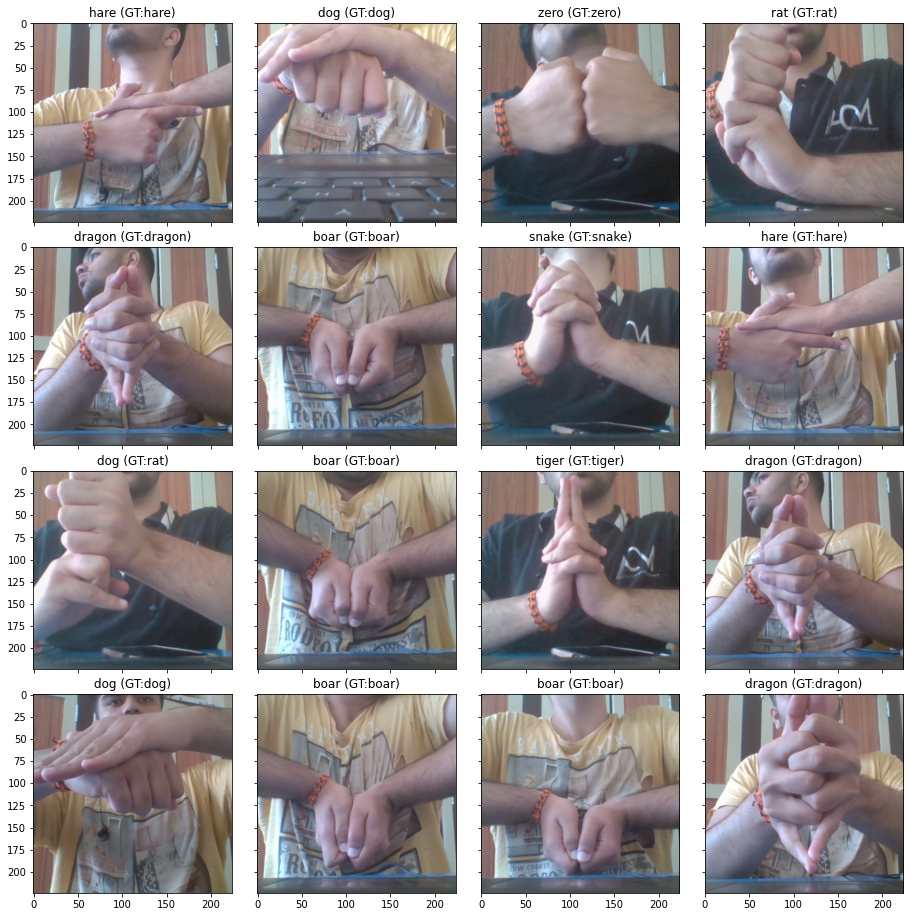

In [0]:
model.eval()
with torch.no_grad():
  X, y = next(iter(test_loader)) 
  #take juste the 16 first
  X = X[0:16].to(device)
  y = y[0:16].to(device)
  preds_indices = torch.argmax(model(X), -1) #transforms model predictions into indices
  #  Show the data then stops
  fig = plt.figure(figsize=(16, 16))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                  nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                  axes_pad=0.35,  # pad between axes in inch.
                  )

  for ax, im, lb, pred in zip(grid, X, y, preds_indices):
    # Iterating over the grid returns the Axes.
    pred = train_dataset.classes[pred]
    inp = np.array(std_nums) * im.permute(1, 2, 0).detach().cpu().numpy() + np.array(mean_nums)
    ax.imshow(inp)
    ax.set_title("{} (GT:{})".format(pred, train_dataset.classes[lb]))

  plt.axis("off")
  plt.ioff()
  plt.show()

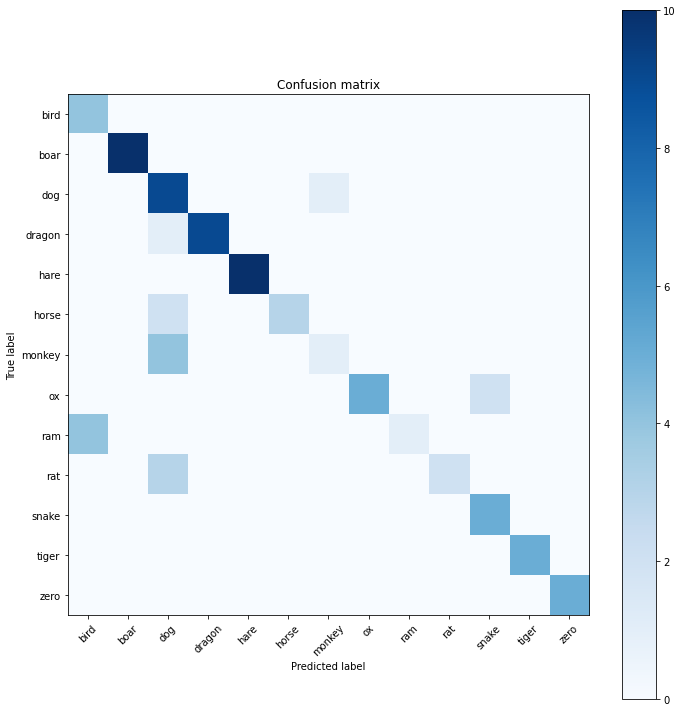

In [0]:
cm = confusion_matrix(all_gt, all_preds)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, train_dataset.classes)

In [0]:
from google.colab import drive
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.
